导入包

In [1]:
import torch as th 
th.backends.cudnn.benchmark = True

In [2]:
from mainNet import Decoder_Train_Net

train_net = Decoder_Train_Net(True).cuda()

加载数据

In [5]:
from dataloader import ImageLoder
from torch.utils.data import DataLoader

dataset = DataLoader(dataset= ImageLoder(r"./data\train2014", 3000, True, preload= True), 
                     batch_size= 4, 
                     shuffle= True, 
                     num_workers= 4
                
)

In [ ]:
for i in dataset: 
    print(i)

加载优化器、训练调整器、损失函数

In [6]:
optimizer = th.optim.Adam(train_net.decoder.parameters(), lr= 0.001)

In [7]:
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'min', 
                                                    factor= 0.5, patience= 5, 
                                                    verbose= True, min_lr= 1e-4)

In [8]:
from lossFunction import Decoder_Train_Loss

loss_fn = Decoder_Train_Loss().cuda()

设置训练轮次，加载预训练解码器

In [9]:
epochs = 20

In [10]:
now_epoch= 1

In [3]:
train_net.decoder.load_state_dict(th.load(r"pretrained_models\decoder1.4.pth"))

<All keys matched successfully>

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(utils.get_logPath(r"./logs"))

训练

In [11]:
sum = dataset.__len__()

In [12]:
train_net.train()
for _ in range(epochs): 
    loss_all = 0 
    print("epoch: {:d}".format(now_epoch))
    for img in dataset:
        img = img.cuda()
        train_net(img)
        
        loss = loss_fn(train_net.dlist ,train_net.elist)
        
        loss_all += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    scheduler.step(loss_all)
    # writer.add_scalar("loss", loss_all, now_epoch)
    print("loss: ", loss_all / sum)
    now_epoch += 1

epoch: 1
loss:  4.901796392758687
epoch: 2
loss:  4.8165653670628865
epoch: 3
loss:  4.772576805432638
epoch: 4
loss:  4.745935479799907
epoch: 5
loss:  4.727469685236613
epoch: 6
loss:  4.70926829179128
epoch: 7
loss:  4.696146695454916
epoch: 8
loss:  4.678281217257182
epoch: 9
loss:  4.6687396742502845
epoch: 10
loss:  4.658064468383789
epoch: 11
loss:  4.651322841326396
epoch: 12
loss:  4.65137369632721
epoch: 13


KeyboardInterrupt: 

梯度检查

In [13]:
for name, parms in train_net.decoder.named_parameters():
	print('-->name:', name, '--weight', th.mean(parms.data), ' -->grad_value:', th.mean(parms.grad))

-->name: 0.1.weight --weight tensor(-0.0064, device='cuda:0')  -->grad_value: tensor(2.5648e-06, device='cuda:0')
-->name: 0.1.bias --weight tensor(0.0787, device='cuda:0')  -->grad_value: tensor(6.8567e-06, device='cuda:0')
-->name: 0.5.weight --weight tensor(-0.0066, device='cuda:0')  -->grad_value: tensor(2.6437e-05, device='cuda:0')
-->name: 0.5.bias --weight tensor(-0.0165, device='cuda:0')  -->grad_value: tensor(5.5966e-05, device='cuda:0')
-->name: 0.8.weight --weight tensor(-0.0067, device='cuda:0')  -->grad_value: tensor(5.7699e-07, device='cuda:0')
-->name: 0.8.bias --weight tensor(-0.2214, device='cuda:0')  -->grad_value: tensor(1.2590e-05, device='cuda:0')
-->name: 0.11.weight --weight tensor(-0.0201, device='cuda:0')  -->grad_value: tensor(-2.7111e-06, device='cuda:0')
-->name: 0.11.bias --weight tensor(0.6034, device='cuda:0')  -->grad_value: tensor(-5.2102e-05, device='cuda:0')
-->name: 1.1.weight --weight tensor(-0.0087, device='cuda:0')  -->grad_value: tensor(3.0807e-0

模型保存

In [ ]:
th.save(train_net.decoder.state_dict(), r"./pretrained_models/decoder1.5.pth")

测试

In [14]:
import utils
import numpy as np
img = utils.get_pilimg(r"data\test\Lenna.png")
img_tensor = utils.pilimg2tensor(img, cuda= True)

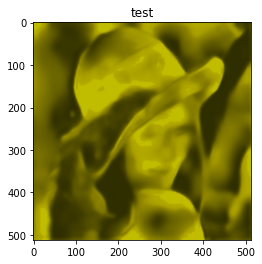

In [15]:
train_net.eval()
output = train_net(img_tensor)
r_img = utils.tensor2img(output)
utils.img_display(r_img, 'test')